In [1]:
import numpy as np
import xarray as xr
import matplotlib as mpl 
from scipy.stats import linregress 

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import xesmf as xe 

from src import  utils
from concurrent.futures import ProcessPoolExecutor

%load_ext autoreload
%autoreload 2

In [2]:
# DEFINE DIRECTORIES HERE
ERSST_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/ERSST/"
HADIS_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/HadISST/"
COBES_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/COBE_SST2/"

GPCC_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/GPCC/full_v2020/"
CRUT_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/CRU_TS4.06/"
APHR_DIR = "/home/eleroy/proj-dirs/SEAM/data/ExtData/APHRODITE/"

In [3]:
# List of CESM2 Ensemble Members
members = ['LE2-1001.001', 'LE2-1011.001', 'LE2-1021.002', 'LE2-1031.002', 'LE2-1041.003', 'LE2-1051.003',
            'LE2-1061.004', 'LE2-1071.004', 'LE2-1081.005', 'LE2-1091.005', 'LE2-1101.006', 'LE2-1111.006',
            'LE2-1121.007', 'LE2-1131.007', 'LE2-1141.008', 'LE2-1151.008', 'LE2-1161.009', 'LE2-1171.009',
            'LE2-1181.010', 'LE2-1191.010', 
            'LE2-1231.001', 'LE2-1231.002', 'LE2-1231.003', 'LE2-1231.004',
            'LE2-1231.005', 'LE2-1231.006', 'LE2-1231.007', 'LE2-1231.008', 'LE2-1231.009', 'LE2-1231.010',
            'LE2-1231.011', 'LE2-1231.012', 'LE2-1231.013', 'LE2-1231.014', 'LE2-1231.015', 'LE2-1231.016',
            'LE2-1231.017', 'LE2-1231.018', 'LE2-1231.019', 'LE2-1231.020',
            'LE2-1251.001', 'LE2-1251.002', 'LE2-1251.003', 'LE2-1251.004',
            'LE2-1251.005', 'LE2-1251.006', 'LE2-1251.007', 'LE2-1251.008', 'LE2-1251.009', 'LE2-1251.010',
            'LE2-1251.011', 'LE2-1251.012', 'LE2-1251.013', 'LE2-1251.014', 'LE2-1251.015', 'LE2-1251.016',
            'LE2-1251.017', 'LE2-1251.018', 'LE2-1251.019', 'LE2-1251.020',
            'LE2-1301.001', 'LE2-1301.002', 'LE2-1301.003', 'LE2-1301.004', 'LE2-1301.005', 'LE2-1301.006',
            'LE2-1301.007', 'LE2-1301.008', 'LE2-1301.009', 'LE2-1301.010', 'LE2-1301.011', 'LE2-1301.012', 
            'LE2-1301.013', 'LE2-1301.014', 'LE2-1301.015', 'LE2-1301.016', 'LE2-1301.017', 'LE2-1301.018',
            'LE2-1301.019', 'LE2-1301.020',
            'LE2-1281.001', 'LE2-1281.002', 'LE2-1281.003', 'LE2-1281.004', 'LE2-1281.005', 'LE2-1281.006',
            'LE2-1281.007', 'LE2-1281.008', 'LE2-1281.009', 'LE2-1281.010', 'LE2-1281.011', 'LE2-1281.012',
            'LE2-1281.013', 'LE2-1281.014', 'LE2-1281.015', 'LE2-1281.016', 'LE2-1281.017', 'LE2-1281.018',
            'LE2-1281.019', 'LE2-1281.020']
print(len(members))

100


In [140]:
# Open all precip. datasets
precip_anm_G = utils.get_obs_precip_anomalies(
    source="GPCC", 
    months=[3, 4, 5], detrend=True
    )

precip_anm_C = utils.get_obs_precip_anomalies(
    source="CRUT", 
    months=[3, 4, 5], detrend=True
    )

precip_anm_A = utils.get_obs_precip_anomalies(
    source="APHR", 
    months=[3, 4, 5], detrend=True
    )

In [141]:
# Open all Nino3.4 SST datasets
sst_anm_nino34_E = utils.get_obs_nino34_sst_anomalies(
    source="ERSST",
    detrend=True
)

sst_anm_nino34_H = utils.get_obs_nino34_sst_anomalies(
    source="HADISST", 
    detrend=True
)

sst_anm_nino34_C = utils.get_obs_nino34_sst_anomalies(
    source="COBESST", 
    detrend=True
)

In [6]:
def plot_line(x, y, ax, color, linewidth=1):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    ax.plot(x_fit, y_fit, color=color, linestyle='-', linewidth=linewidth)
    
    return slope


In [147]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]

In [8]:
# Open CESM2-LE data for running correlation
N=13 # running mean correlation
def process_member(ens):
    print(f"Processing {ens}")
    monthly_sst_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.SST.Nino34.nc")
    sst_anm = utils.get_model_sst_anomalies(monthly_sst_da, detrend=False)
    
    prec_da = xr.open_dataset(f"/home/eleroy/proj-dirs/SEAM/data/analysis_data/CESM-LE2_cropped_data/{ens}.PRECT.MSEA.nc")
    precip_anm = utils.get_model_precip_anomalies(prec_da, months=[3,4,5], detrend=False)

    print("Getting running correlation...")
    corr_lead = utils.get_running_corr(precip_anm, sst_anm.shift(time=1), window=N)
    
    return (corr_lead, precip_anm, sst_anm)
    
def main(members):
    lead_correlations = []
    all_precips = []
    all_ssts = []
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_member, members))
    for result in results:
        corr_lead, precip_anm, sst_anm = result
        lead_correlations.append(corr_lead)
        all_precips.append(precip_anm)
        all_ssts.append(sst_anm)
    return lead_correlations, all_precips, all_ssts

lead_correlations, all_precips, all_ssts = main(members)

Processing LE2-1001.001


Processing LE2-1011.001
Processing LE2-1021.002
Processing LE2-1031.002
Processing LE2-1041.003
Processing LE2-1051.003
Processing LE2-1061.004
Processing LE2-1071.004
Processing LE2-1081.005
Processing LE2-1091.005
Processing LE2-1101.006
Processing LE2-1111.006
Processing LE2-1121.007
Processing LE2-1131.007
Processing LE2-1141.008
Processing LE2-1151.008
Processing LE2-1161.009
Processing LE2-1171.009
Processing LE2-1181.010
Processing LE2-1191.010
Processing LE2-1231.001
Processing LE2-1231.004Processing LE2-1231.003Processing LE2-1231.002


Processing LE2-1231.005
Processing LE2-1231.006
Getting running correlation...Getting running correlation...

Processing LE2-1231.007Processing LE2-1231.009Processing LE2-1231.008


Processing LE2-1231.010
Getting running correlation...
Processing LE2-1231.011
Processing LE2-1231.012Processing LE2-1231.013

Getting running correlation...
Getting running correlation...
Processing LE2-1231.014
Getting running correlation...Processing LE2-1231.015

In [9]:
lead_correlations_da = xr.concat(lead_correlations, dim='ensemble')
precips_da = xr.concat(all_precips, dim='ensemble')
ssts_da = xr.concat(all_ssts, dim='ensemble')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_2994926/2016301487.py:108: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.png")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


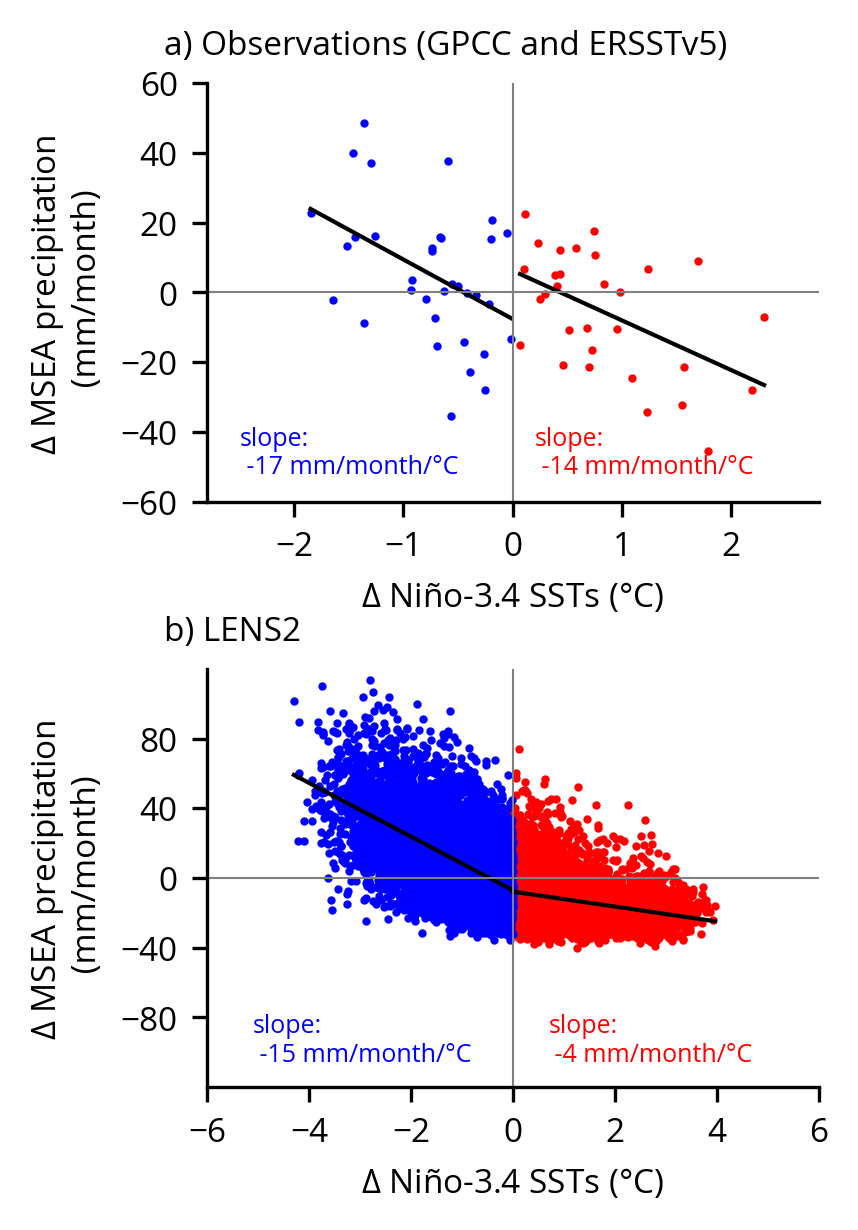

In [10]:

%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 7
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 1, top=0.95, bottom=0.10, left=0.24, right=0.98, hspace=0.4, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])

############## Figure 4a ##############

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax1.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax1.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.2, -52, f'slope:\n {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-2.5, -52, f'slope:\n {slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############

sst_shifted = ssts_da.shift(time=1)

precip_anm = precips_da.sel(time=slice('1900','2015'))
sst_shifted = sst_shifted.sel(time=slice('1900','2015'))

elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


ax2.scatter(elnino_sst, elnino_pre,color="red", s=1)
ax2.scatter(lanina_sst, lanina_pre,color="blue", s=1)

slope = plot_line(elnino_sst[~np.isnan(elnino_sst)].flatten(), elnino_pre[~np.isnan(elnino_pre)].flatten(), ax=ax2, color='black')
ax2.text(0.7, -105, f'slope:\n {slope:.0f} mm/month/°C', color='red', fontsize=6)
slope = plot_line(lanina_sst[~np.isnan(lanina_sst)].flatten(), lanina_pre[~np.isnan(lanina_pre)].flatten(), ax=ax2, color='black')
ax2.text(-5.1, -105, f'slope:\n {slope:.0f} mm/month/°C', color='blue', fontsize=6)

ax1.set_xlim(-2.8,2.8)
ax2.set_xlim(-6, 6)

ax1.set_ylim(-60,60)
ax2.set_ylim(-120,120)
ax2.set_yticks([-80, -40, 0, 40, 80])

ax2.legend()

for ax in [ax1, ax2]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)


# Set subplot labels
titles1 = ["a) Observations (GPCC and ERSSTv5)", "b) LENS2"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("Fig4.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


/tmp/ipykernel_2994926/2145306640.py:113: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("FigS6.png")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


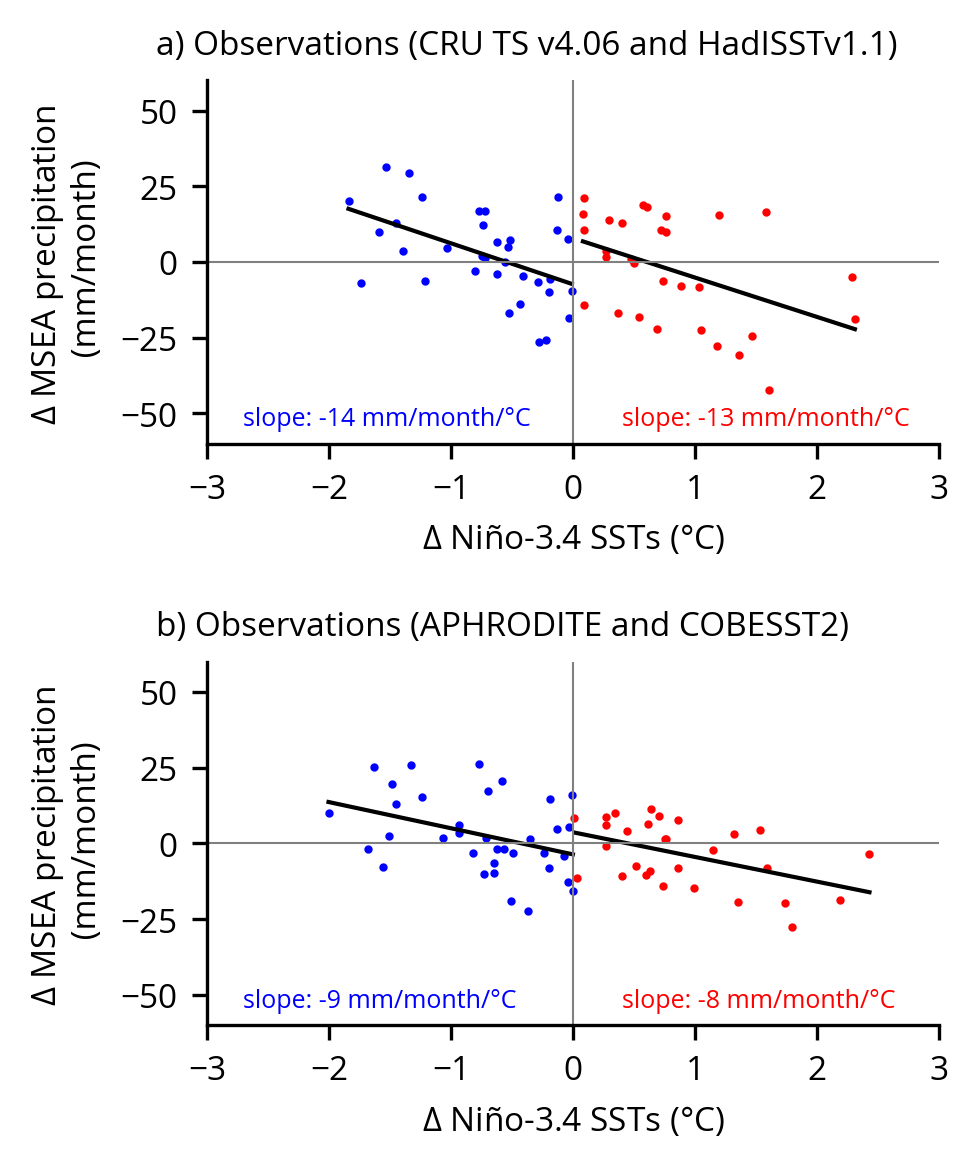

In [11]:
%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 8
fig_height_cm = 10
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(2, 1, top=0.90, bottom=0.10, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[1, 0])

############## Figure 4a ##############

precip_anms = [
    precip_anm_C # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_H #E,H,C
]


for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax1.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax1.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.4, -54, f'slope: {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-2.7, -54, f'slope: {slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############


precip_anms = [
    precip_anm_A # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_C #E,H,C
]

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values


    ax2.scatter(elnino_sst,elnino_pre,color="red", s=1)
    ax2.scatter(lanina_sst,lanina_pre,color="blue", s=1)
    
    slope = plot_line(elnino_sst, elnino_pre, ax=ax2, color='k')
    ax2.text(0.4, -54, f'slope: {slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax2, color='k')
    ax2.text(-2.7, -54, f'slope: {slope:.0f} mm/month/°C', color='blue', fontsize=6)


for ax in [ax1, ax2]:
    ax.set_xlim(-3,3)
    ax.set_ylim(-60,60)
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)


# Set subplot labels
titles1 = ["a) Observations (CRU TS v4.06 and HadISSTv1.1)", "b) Observations (APHRODITE and COBESST2)"]
titles2 = [None, None]
colors = ['k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.05), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')

plt.savefig("FigS6.png")


In [12]:
from typing import Pattern, List
import os 


def get_file_list(directory_path: str, compiled_regex: Pattern):
    """Return a list of file paths in a directory matching the regex pattern.

    Args:
        directory_path (str): path to directory where to look for files
        compiled_regex (pattern): compiled regex pattern to match

    Returns:
        file_list (list[str]): list of file paths

    """

    file_list = []
    for file_name in os.listdir(directory_path):
        if compiled_regex.match(file_name):
            file_list.append(os.path.join(directory_path, file_name))

    # Important!!! Sort to concatenate chronologically
    file_list.sort()

    return file_list

In [190]:
models = ['ACCESS-CM2', 
          'ACCESS-ESM1-5', 
          'BCC-CSM2-MR', 
          'BCC-ESM1',
          'CAMS-CSM1-0',
          'CanESM5', 
          'CAS-ESM2-0',
          'CESM2-FV2',
          'CESM2-WACCM-FV2', 
          #'CESM2-WACCM',
          'CIESM', 
          'E3SM-1-0', 
          'E3SM-1-1-ECA',
          'E3SM-1-1', 
          'E3SM-2-0',
          'E3SM-2-0-NARRM',
          'EC-Earth3-AerChem',
          'EC-Earth3-CC', 
          'EC-Earth3', 
          'EC-Earth3-Veg-LR', 
          'FGOALS-g3', 
          'FGOALS-f3-L',
          'FIO-ESM-2-0', 
          'GFDL-CM4',
          'GFDL-ESM4', 
          'GISS-E2-1-G', 
          'GISS-E2-1-H',
          'GISS-E2-2-H',
          #'IITM-ESM', download failed
          'INM-CM4-8', 
          'INM-CM5-0', 
          'IPSL-CM6A-LR', 
          'KACE-1-0-G',
           #'KIOST-ESM', download failed
          'MCM-UA-1-0', 
          'MIROC6', 
          'MPI-ESM-1-2-HAM', 
          'MPI-ESM1-2-HR', 
          'MPI-ESM1-2-LR',
          'MRI-ESM2-0', 
          'NESM3', 
          'NorCPM1',
          'NorESM2-LM', 
          'NorESM2-MM', 
          'SAM0-UNICON']


In [191]:
import os

# Define the directory path
tos_dir = '/net/fs03/d0/eleroy/data-dirs/SEAM/data/ExtData/CMIP6/historical/r1i1p1f1/Omon/tos'
pr_dir = '/net/fs03/d0/eleroy/data-dirs/SEAM/data/ExtData/CMIP6/historical/r1i1p1f1/Amon/pr'

# List of distinct models you want to filter

# Dictionary to store model files with full paths
tos_files = {model: [] for model in models}
pr_files = {model: [] for model in models}

# Loop through all files in the directory
for file_name in os.listdir(tos_dir):
    # Check for exact model name matches in the file names
    for model in models:
        # Ensure that the model name appears in the file name followed by an underscore or end of file (precise match)
        if f"_{model}_" in file_name or file_name.endswith(f"_{model}.nc"):
            # Append the full file path
            full_path = os.path.join(tos_dir, file_name)
            tos_files[model].append(full_path)

# Loop through all files in the directory
for file_name in os.listdir(pr_dir):
    # Check for exact model name matches in the file names
    for model in models:
        # Ensure that the model name appears in the file name followed by an underscore or end of file (precise match)
        if f"_{model}_" in file_name or file_name.endswith(f"_{model}.nc"):
            # Append the full file path
            full_path = os.path.join(pr_dir, file_name)
            pr_files[model].append(full_path)

# Print the list of full file paths for each model
#for model, files in tos_files.items():
#    print(f"Files for model {model}:")
#    for file in files:
#        print(f"  {file}")
#    print("\n")

# Print the list of full file paths for each model
#for model, files in pr_files.items():
#    print(f"Files for model {model}:")
#    for file in files:
#        print(f"  {file}")
#    print("\n")

In [192]:

ds_out = xr.open_mfdataset(tos_files['E3SM-1-0'])


def get_cmip6_da(file):
    da = xr.open_mfdataset(file, engine='netcdf4')

    if da.parent_source_id == "CIESM":
        if "pr" in da.variables:
            da = da*1e3

    if "lat" in da.coords and "lon" in da.coords:
        return da
    elif "latitude" in da.coords and "longitude" in da.coords:
        da = da.rename({"latitude": "lat", "longitude": "lon"})
    elif "nav_lat" in da.coords and "nav_lon" in da.coords:
        da = da.rename({"nav_lat": "lat", "nav_lon": "lon"})

    # Check for negative longitude values:
    if (da.lon < 0).any():
        da.coords['lon'] = (da.coords['lon'] % 360)
        #TODO: Check if I need to reindex?
        #da = da.sortby(da.lon)

    if "bnds" in da.coords:  # and "lon" in da.coords:
        da = da.drop_dims(["bnds"])
    if "vertices" in da.coords:
        da = da.drop_dims(["vertices"])
    if "nvertex" in da.coords:
        da = da.drop_dims(["nvertex"])
    if "axis_nbounds" in da.coords:
        da = da.drop_dims(["axis_nbounds"])

    if "i" in da.coords:  # and "lon" in da.coords:
        regridder = xe.Regridder(da, ds_out, 'nearest_s2d')
    elif "x" in da.dims:  # and "lon" in da.coords:
        print("yes")
        regridder = xe.Regridder(da, ds_out, 'nearest_s2d')
    else:
        regridder = xe.Regridder(da, ds_out, 'bilinear')
    
    da_new = regridder(da)

    return da_new

    #if ('i' in da.dims) and ('j' in da.dims):
    #    print("i in dims")
    #    da = xr.decode_cf(da)

    #if np.all(np.diff(da.lat) < 0):
    #    da = da.reindex(lat=list(reversed(da['lat'])))

    # Check for negative longitude values:
    #if (da.lon < 0).any():
    #    da.coords['lon'] = (da.coords['lon'] % 360)


#problem_models = ['E3SM-1-1', 'GFDL-CM4','GFDL-ESM4']
#models = ['E3SM-1-1-ECA', 'E3SM-1-0', 'CESM2', 'CESM2-WACCM', 'MRI-ESM2-0', 'KACE-1-0-G']

#problem_models_pr = ['E3SM-1-1-ECA', 'E3SM-1-1', 'GFDL-CM4','GFDL-ESM4','E3SM-1-0',  ]
#models = ['CESM2', 'CESM2-WACCM', 'MRI-ESM2-0', 'KACE-1-0-G']

#for model in models:
    #print(model)
    #da = get_cmip6_da(pr_files[model])
    #print("done pr!")

    #da = get_cmip6_da(tos_files[model])
    #print("done tos!")


In [193]:
from seam import precip, nino34

def get_precip_sst(da_pr, da_tos):
    precip_anm = (
        precip.get_SEAM_anm_timeseries(
            da_pr,
            detrend=False,
            base_start='1951-01',
            base_end='2015-12',
            monsoon_season=False,
            monthly=True)
        )

    precip_MAM = precip_anm.sel(time=precip_anm.time.dt.season=="MAM")
    precip_anm = precip_MAM.resample(time="1Y").mean()

    sst_anm_nino34_ersst = (
        nino34.get_nino34_anm_timeseries(
            da_tos, 
            detrend=False, 
            base_start='1951-01',
            base_end='2015-12', 
            filtered=False
        )
        )
    sst_season = (
        sst_anm_nino34_ersst.resample(time="QS-DEC", label="left")
            .mean(dim='time')
        )  # take quarterly means starting Dec 1

    nino34_DJF_ersst = (
        sst_season.sel(time=sst_season.time.dt.month.isin([12]))
        .resample(time="1Y")
        .mean()
        )

    return precip_anm.sel(time=slice('1900','2014')), nino34_DJF_ersst.sel(time=slice('1900','2014'))


In [194]:
cmip6_precip_anms = []
cmip6_tos_anms = []

sorted_models = sorted(models)

for model in sorted_models:
    print(model)
    ds_tos = get_cmip6_da(tos_files[model])
    ds_pr = get_cmip6_da(pr_files[model])

    da_tos = ds_tos['tos'].sel(time=slice('1900','2014'))
    da_pr = ds_pr['pr'].sel(time=slice('1900','2014'))

    da_pr = da_pr * 30 * 24 *60 *60 # days × 24 hours/day × 60 minutes/hour × 60 seconds/minute)

    precip_anm, nino34_DJF_ersst = get_precip_sst(da_pr, da_tos)

    cmip6_precip_anms.append(precip_anm)
    cmip6_tos_anms.append(nino34_DJF_ersst)
    print(model)



ACCESS-CM2
ACCESS-CM2
ACCESS-ESM1-5
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-CSM2-MR
BCC-ESM1
BCC-ESM1
CAMS-CSM1-0
CAMS-CSM1-0
CAS-ESM2-0
CAS-ESM2-0
CESM2-FV2


/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/con

CESM2-FV2
CESM2-WACCM-FV2


/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/conventions.py:448: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/xarray/co

CESM2-WACCM-FV2
CIESM
CIESM
CanESM5
CanESM5
E3SM-1-0
E3SM-1-0
E3SM-1-1
E3SM-1-1
E3SM-1-1-ECA
E3SM-1-1-ECA
E3SM-2-0
E3SM-2-0
E3SM-2-0-NARRM
E3SM-2-0-NARRM
EC-Earth3
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-CC
EC-Earth3-Veg-LR
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-f3-L
FGOALS-g3
FGOALS-g3
FIO-ESM-2-0
FIO-ESM-2-0
GFDL-CM4
GFDL-CM4
GFDL-ESM4
GFDL-ESM4
GISS-E2-1-G
GISS-E2-1-G
GISS-E2-1-H
GISS-E2-1-H
GISS-E2-2-H
GISS-E2-2-H
INM-CM4-8
INM-CM4-8
INM-CM5-0
INM-CM5-0
IPSL-CM6A-LR
yes
IPSL-CM6A-LR
KACE-1-0-G
KACE-1-0-G
MCM-UA-1-0
MCM-UA-1-0
MIROC6
yes
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MPI-ESM1-2-LR
MRI-ESM2-0
MRI-ESM2-0
NESM3
NESM3
NorCPM1
NorCPM1
NorESM2-LM
NorESM2-LM
NorESM2-MM
NorESM2-MM
SAM0-UNICON
SAM0-UNICON


In [195]:
colors = plt.cm.get_cmap('tab20b', 34)  # 'tab20b' or 'tab20', 'Set3', 'tab10' etc.


NESM3


/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


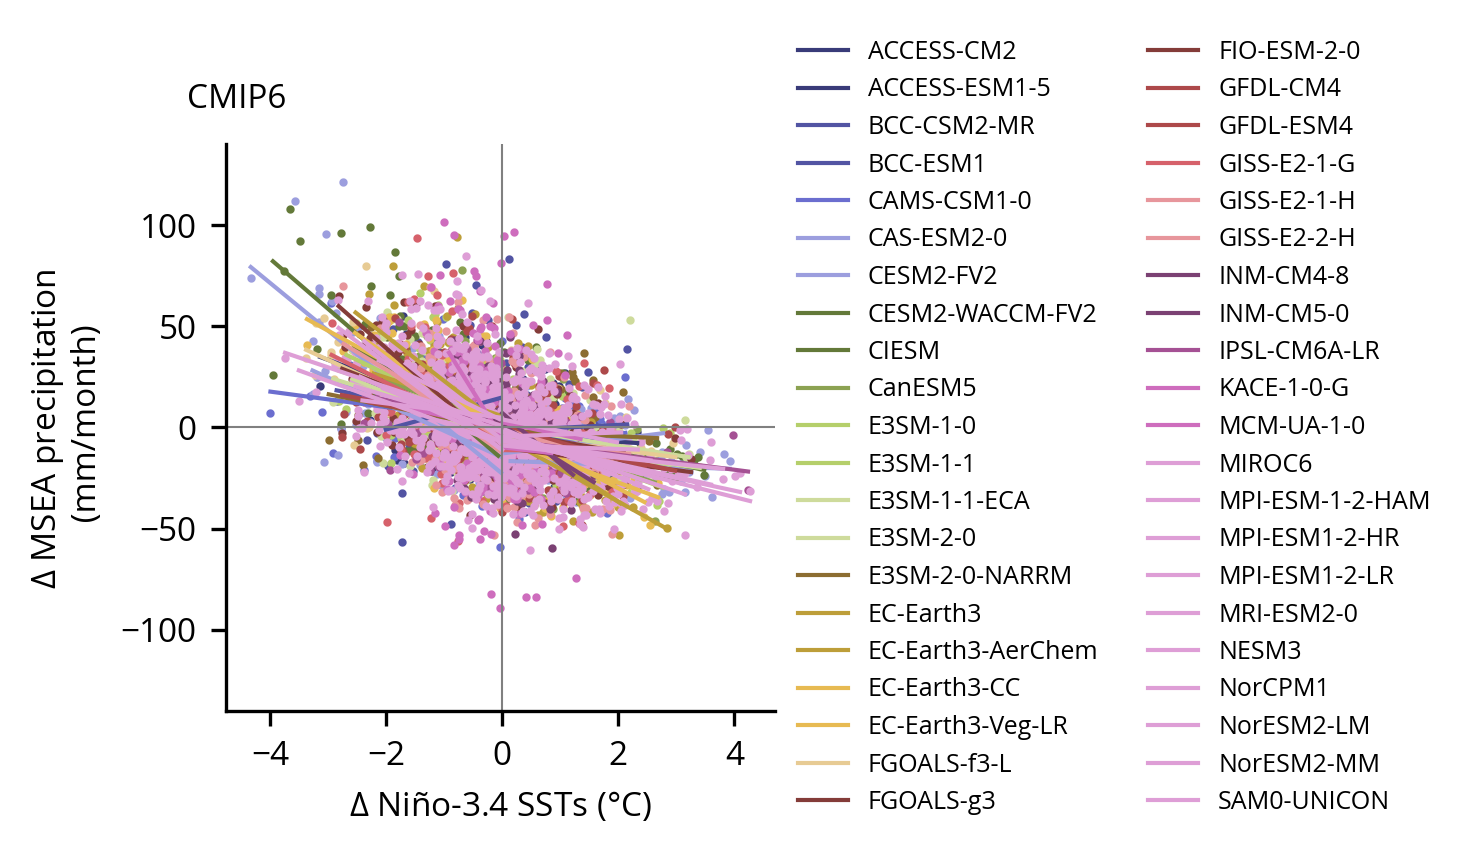

In [196]:
def plot_line(x, y, ax, color, label=None, linewidth=1):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    # Plot the line with label (label will be used in the legend)
    ax.plot(x_fit, y_fit, color=color, linestyle='-', linewidth=linewidth, label=label)
    
    return slope
    

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec

# Define unique colors for each model (assuming you have N models)
#N = len(sorted_models)
#colors = plt.cm.get_cmap('tab10', N)  # Using 'tab10' colormap which gives 10 different colors

colors = plt.cm.get_cmap('tab20b', 34)  # 'tab20b' or 'tab20', 'Set3', 'tab10' etc.


utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})


fig_width_cm = 6
fig_height_cm = 6
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 1, top=0.90, bottom=0.10, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])

# Prepare lists to store slope values
slope_elninos = []
slope_laninas = []

# Loop through each model and plot with a unique color for both El Niño and La Niña
for idx, (precip_anm, sst_anm_nino34) in enumerate(zip(cmip6_precip_anms, cmip6_tos_anms)):
    if sorted_models[idx]=="NESM3":
        print("NESM3")
        precip_anm['time']=sst_anm_nino34['time']
    sst_shifted = sst_anm_nino34.shift(time=1)
    
    #precip_anm = precip_anm.sel(time=slice('1951', '2015'))
    #sst_shifted = sst_shifted.sel(time=slice('1951', '2015'))

    elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

    # Plot El Niño and La Niña points with the same unique color for each model
    ax1.scatter(elnino_sst, elnino_pre, color=colors(idx), s=1, alpha=1)
    ax1.scatter(lanina_sst, lanina_pre, color=colors(idx), s=1, alpha=1)
    
    # Plot the slope lines for both El Niño and La Niña events with a label for each model
    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color=colors(idx), label=f'{sorted_models[idx]}')
    slope_elninos.append(slope)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color=colors(idx))
    slope_laninas.append(slope)

# Collect all data points for x < 0 and x > 0
elnino_sst_all = []
elnino_pre_all = []
lanina_sst_all = []
lanina_pre_all = []

for precip_anm, sst_anm_nino34 in zip(cmip6_precip_anms, cmip6_tos_anms):
    sst_shifted = sst_anm_nino34.shift(time=1)


    elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

    # Append all points
    elnino_sst_all.extend(elnino_sst)
    elnino_pre_all.extend(elnino_pre)
    lanina_sst_all.extend(lanina_sst)
    lanina_pre_all.extend(lanina_pre)

# Plot single lines for x > 0 and x < 0
#slope_elnino = plot_line(elnino_sst_all, elnino_pre_all, ax=ax1, color='k', linewidth=2)
#ax1.text(0.4, -74, f'Mean slope: \n {slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)

#slope_lanina = plot_line(lanina_sst_all, lanina_pre_all, ax=ax1, color='k', linewidth=2)
#ax1.text(-3.7, -74, f'Mean slope: \n {slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)


# Add labels, lines, and legend
ax1.set_ylim(-140, 140)
ax1.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(0, color='grey', linewidth=0.5)
ax1.axvline(0, color='grey', linewidth=0.5)

# Adjust the legend: place it to the right, with 3 columns
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=6, ncol=2)

# Set subplot titles if needed
ax1.annotate("CMIP6", xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')

plt.show()


In [197]:
GPMs = [
    #"CESM2-WACCM-FV2",
    "E3SM-1-1",
    "E3SM-1-1-ECA",
    "EC-Earth3",
    "E3SM-1-0",
    "ACCESS-CM2",
    "EC-Earth3-Veg-LR",
    "CIESM",
    "GISS-E2-1-H",
    "EC-Earth3-AerChem",
    "FGOALS-g3",
    "MRI-ESM2-0",
]

In [198]:
sorted_models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CAS-ESM2-0',
 'CESM2-FV2',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CanESM5',
 'E3SM-1-0',
 'E3SM-1-1',
 'E3SM-1-1-ECA',
 'E3SM-2-0',
 'E3SM-2-0-NARRM',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-H',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MCM-UA-1-0',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON']

In [199]:
non_cesm_models = ['SAM0-UNICON', 'EC-Earth3-CC', 'NorCPM1', 'EC-Earth3-AerChem', 'FGOALS-g3', 'EC-Earth3-Veg-LR', 'EC-Earth3', 'INM-CM5-0', 'INM-CM4-8', 'IPSL-CM6A-LR', 'CIESM', 'MPI-ESM-1-2-HAM', 'NorESM2-LM', 'GISS-E2-1-G', 'GISS-E2-1-H','ACCESS-CM2', 'MRI-ESM2-0', 'BCC-CSM2-MR', 'BCC-ESM1', 'CAMS-CSM1-0', 'CanESM5', 'FIO-ESM-2-0', 'ACCESS-ESM1-5', 'MIROC6', 'MPI-ESM1-2-HR', 'MPI-ESM1-2-LR', 'NESM3', 'NorESM2-MM', 'MCM-UA-1-0', 'E3SM-1-1', 'GFDL-CM4','GFDL-ESM4', 'E3SM-1-1-ECA', 'E3SM-1-0', 'KACE-1-0-G']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ACCESS-CM2
yes!
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2-FV2
CESM2-WACCM-FV2
CIESM
yes!
CanESM5
E3SM-1-0
yes!
E3SM-1-1
yes!
E3SM-1-1-ECA
yes!
E3SM-2-0
E3SM-2-0-NARRM
EC-Earth3
yes!
EC-Earth3-AerChem
yes!
EC-Earth3-CC
EC-Earth3-Veg-LR
yes!
FGOALS-f3-L
FGOALS-g3
yes!
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
GISS-E2-1-H
yes!
GISS-E2-2-H
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MCM-UA-1-0
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
yes!
NESM3
NorCPM1
NorESM2-LM
NorESM2-MM
SAM0-UNICON
[0.6263257397440208, 0.2460463622229466, 0.8940791087534042, 0.047945619068722974, 1.071599958190365, 0.4744157695373119, 0.37037294776042456, 1.5661409220378981, 0.7549251006377325, 0.41881922201037236, 0.45774632121155084, 0.71265985154881, 0.1899505077610454, 0.6509659453457037, 1.000863601280798, 0.35687963994934074, 0.6430084979151184, 0.7523673501702076, 0.37702476406009494, 0.23860084051092792, 0.09184683470794407, 0.31664502907237907, 1.867469445536428, 0.8

/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


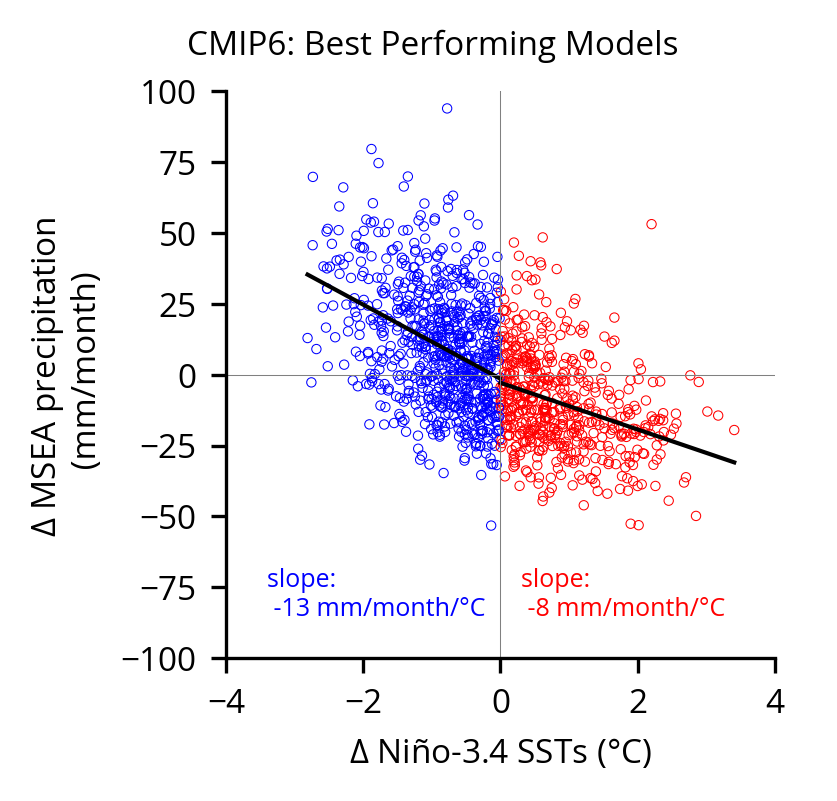

In [200]:
def plot_line(x, y, ax, color, label=None, linewidth=1):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    # Plot the line with label (label will be used in the legend)
    ax.plot(x_fit, y_fit, color=color, linestyle='-', linewidth=linewidth, label=label)
    
    return slope
    

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec

# Define unique colors for each model (assuming you have N models)
N = len(precip_anms)
colors = plt.cm.get_cmap('tab10', N)  # Using 'tab10' colormap which gives 10 different colors

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})


fig_width_cm = 6
fig_height_cm = 6
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 1, top=0.90, bottom=0.10, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])

# Prepare lists to store slope values
slope_elninos = []
slope_laninas = []

# Loop through each model and plot with a unique color for both El Niño and La Niña
for idx, (precip_anm, sst_anm_nino34) in enumerate(zip(cmip6_precip_anms, cmip6_tos_anms)):
    if sorted_models[idx] in GPMs:
        sst_shifted = sst_anm_nino34.shift(time=1)
        
        #precip_anm = #precip_anm.sel(time=slice('1951', '2015'))
        #sst_shifted = #sst_shifted.sel(time=slice('1951', '2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Plot El Niño and La Niña points with the same unique color for each model
        ax1.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='none', s=5, linewidths=0.25, alpha=1)
        ax1.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='none', s=5, linewidths=0.25, alpha=1)
        
        # Plot the slope lines for both El Niño and La Niña events with a label for each model
        #slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color=colors(idx), label=f'{sorted_models[idx]}')
        slope_elninos.append(slope)

        #slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color=colors(idx))
        slope_laninas.append(slope)

# Collect all data points for x < 0 and x > 0
elnino_sst_all = []
elnino_pre_all = []
lanina_sst_all = []
lanina_pre_all = []
for precip_anm, sst_anm_nino34, sorted_model in zip(cmip6_precip_anms, cmip6_tos_anms, sorted_models):
    print(sorted_model)
    if sorted_model in GPMs:
        print("yes!")
        sst_shifted = sst_anm_nino34.shift(time=1)

        #precip_anm = precip_anm.sel(time=slice('1951','2015'))
        #sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Append all points
        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

print(elnino_sst_all)
# Plot single lines for x > 0 and x < 0
slope_elnino = plot_line(elnino_sst_all, elnino_pre_all, ax=ax1, color='k', linewidth=1)
ax1.text(0.3, -85, f'slope: \n {slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)

slope_lanina = plot_line(lanina_sst_all, lanina_pre_all, ax=ax1, color='k', linewidth=1)
ax1.text(-3.4, -85, f'slope: \n {slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)


# Add labels, lines, and legend
ax1.set_ylim(-100, 100)
ax1.set_xlim(-4, 4)

ax1.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(0, color='grey', linewidth=0.25)
ax1.axvline(0, color='grey', linewidth=0.25)

# Adjust the legend: place it to the right, with 3 columns
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=6, ncol=2)

# Set subplot titles if needed
ax1.annotate("CMIP6: Best Performing Models", xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ACCESS-CM2
yes!
ACCESS-ESM1-5
yes!
BCC-CSM2-MR
yes!
BCC-ESM1
yes!
CAMS-CSM1-0
yes!
CAS-ESM2-0
yes!
CESM2-FV2
yes!
CESM2-WACCM-FV2
yes!
CIESM
yes!
CanESM5
yes!
E3SM-1-0
yes!
E3SM-1-1
yes!
E3SM-1-1-ECA
yes!
E3SM-2-0
yes!
E3SM-2-0-NARRM
yes!
EC-Earth3
yes!
EC-Earth3-AerChem
yes!
EC-Earth3-CC
yes!
EC-Earth3-Veg-LR
yes!
FGOALS-f3-L
yes!
FGOALS-g3
yes!
FIO-ESM-2-0
yes!
GFDL-CM4
yes!
GFDL-ESM4
yes!
GISS-E2-1-G
yes!
GISS-E2-1-H
yes!
GISS-E2-2-H
yes!
INM-CM4-8
yes!
INM-CM5-0
yes!
IPSL-CM6A-LR
yes!
KACE-1-0-G
yes!
MCM-UA-1-0
yes!
MIROC6
yes!
MPI-ESM-1-2-HAM
yes!
MPI-ESM1-2-HR
yes!
MPI-ESM1-2-LR
yes!
MRI-ESM2-0
yes!
NESM3
yes!
NorCPM1
yes!
NorESM2-LM
yes!
NorESM2-MM
yes!
SAM0-UNICON
yes!
[0.6263257397440208, 0.2460463622229466, 0.8940791087534042, 0.047945619068722974, 1.071599958190365, 0.4744157695373119, 0.37037294776042456, 1.5661409220378981, 0.7549251006377325, 0.41881922201037236, 0.45774632121155084, 0.71265985154881, 0.1899505077610454, 0.6509659453457037, 1.000863601280798, 0.3568796399

/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


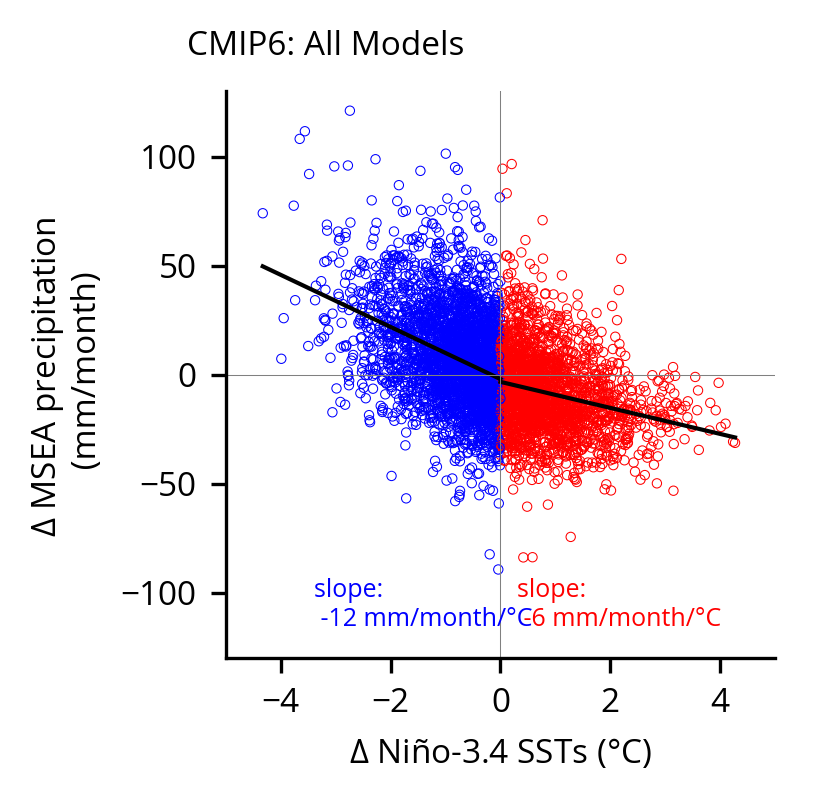

In [201]:
def plot_line(x, y, ax, color, label=None, linewidth=1):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Generate x values for the trend line
    x_fit = np.linspace(np.min(x), np.max(x), 100)
    y_fit = intercept + slope * x_fit

    # Plot the line with label (label will be used in the legend)
    ax.plot(x_fit, y_fit, color=color, linestyle='-', linewidth=linewidth, label=label)
    
    return slope
    

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from matplotlib.gridspec import GridSpec

# Define unique colors for each model (assuming you have N models)
N = len(precip_anms)
colors = plt.cm.get_cmap('tab10', N)  # Using 'tab10' colormap which gives 10 different colors

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})


fig_width_cm = 6
fig_height_cm = 6
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 1, top=0.90, bottom=0.10, hspace=0.6, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])

# Prepare lists to store slope values
slope_elninos = []
slope_laninas = []

# Loop through each model and plot with a unique color for both El Niño and La Niña
for idx, (precip_anm, sst_anm_nino34) in enumerate(zip(cmip6_precip_anms, cmip6_tos_anms)):
    if sorted_models[idx] in sorted_models:
        sst_shifted = sst_anm_nino34.shift(time=1)
        
        #precip_anm = #precip_anm.sel(time=slice('1951', '2015'))
        #sst_shifted = #sst_shifted.sel(time=slice('1951', '2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Plot El Niño and La Niña points with the same unique color for each model
        ax1.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='none', s=5, linewidths=0.25, alpha=1)
        ax1.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='none', s=5, linewidths=0.25, alpha=1)
        
        # Plot the slope lines for both El Niño and La Niña events with a label for each model
        #slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color=colors(idx), label=f'{sorted_models[idx]}')
        #slope_elninos.append(slope)

        #slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color=colors(idx))
        #slope_laninas.append(slope)

# Collect all data points for x < 0 and x > 0
elnino_sst_all = []
elnino_pre_all = []
lanina_sst_all = []
lanina_pre_all = []
for precip_anm, sst_anm_nino34, sorted_model in zip(cmip6_precip_anms, cmip6_tos_anms, sorted_models):
    print(sorted_model)
    if sorted_model in sorted_models:
        print("yes!")
        sst_shifted = sst_anm_nino34.shift(time=1)

        #precip_anm = precip_anm.sel(time=slice('1951','2015'))
        #sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Append all points
        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

print(elnino_sst_all)
# Plot single lines for x > 0 and x < 0
slope_elnino = plot_line(elnino_sst_all, elnino_pre_all, ax=ax1, color='k', linewidth=1)
ax1.text(0.3, -115, f'slope: \n {slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)

slope_lanina = plot_line(lanina_sst_all, lanina_pre_all, ax=ax1, color='k', linewidth=1)
ax1.text(-3.4, -115, f'slope: \n {slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)


# Add labels, lines, and legend
ax1.set_ylim(-130, 130)
ax1.set_xlim(-5, 5)

ax1.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.axhline(0, color='grey', linewidth=0.25)
ax1.axvline(0, color='grey', linewidth=0.25)

# Adjust the legend: place it to the right, with 3 columns
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=6, ncol=2)

# Set subplot titles if needed
ax1.annotate("CMIP6: All Models", xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ACCESS-CM2
ACCESS-ESM1-5
BCC-CSM2-MR
BCC-ESM1
CAMS-CSM1-0
CAS-ESM2-0
CESM2-FV2
CESM2-WACCM-FV2
CIESM
CanESM5
E3SM-1-0
E3SM-1-1
E3SM-1-1-ECA
E3SM-2-0
E3SM-2-0-NARRM
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
GISS-E2-1-G
GISS-E2-1-H
GISS-E2-2-H
INM-CM4-8
INM-CM5-0
IPSL-CM6A-LR
KACE-1-0-G
MCM-UA-1-0
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NESM3
NorCPM1
NorESM2-LM
NorESM2-MM
SAM0-UNICON
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
yes!
[0.6263257397440208, 0.2460463622229466, 0.8940791087534042, 0.047945619068722974, 1.071599958190365, 0.4744157695373119, 0.37037294776042456, 1.5661409220378981, 0.7549251006377325, 0.41881922201037236, 0.45774632121155084, 0.71265985154881, 0.1899505077610454, 0.6509659453457037, 1.000863601280798, 0.3568796399

/tmp/ipykernel_2994926/1350454303.py:189: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig("Fig4.png")
/home/eleroy/.conda/envs/SEAM-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


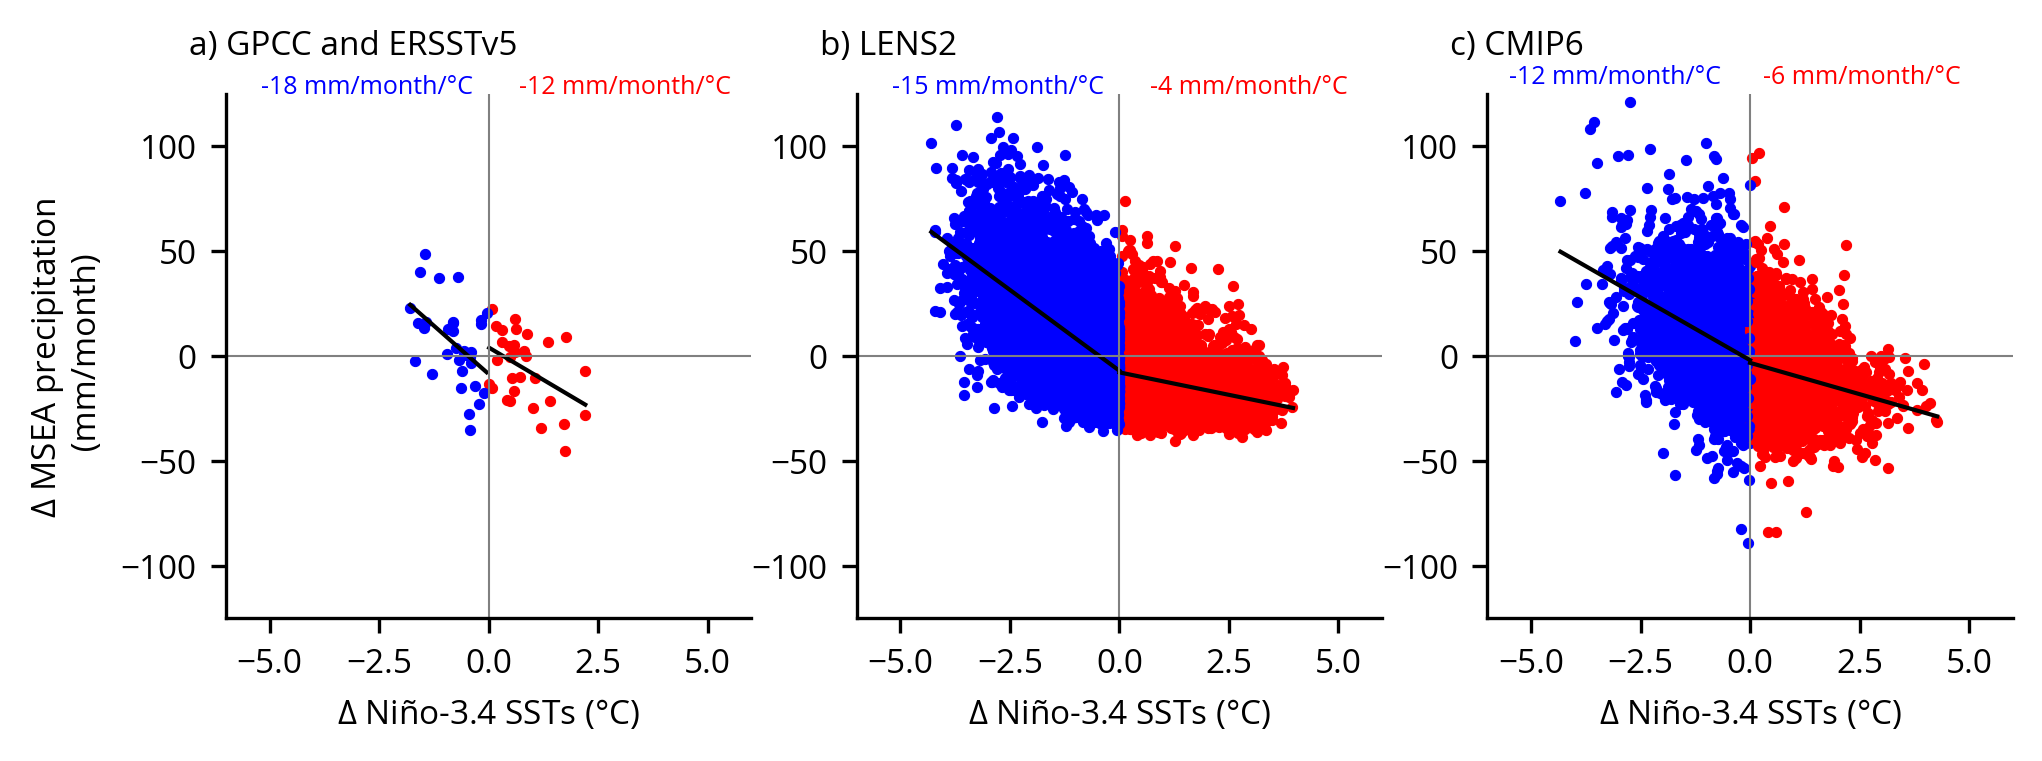

In [202]:
precip_anms = [
    precip_anm_G # G,C,A
]

sst_anm_nino34s = [
    sst_anm_nino34_E #E,H,C
]


%matplotlib inline 

utils.set_matplotlib_font("Open Sans")
mpl.rcParams.update({
    'font.size': 8, 
    'axes.titlesize': 8, 
    'axes.labelsize': 8,
    'xtick.labelsize': 8, 
    'ytick.labelsize': 8, 
    'legend.fontsize': 8,
    'figure.titlesize': 8
})

fig_width_cm = 17
fig_height_cm = 6
fig_width_in = fig_width_cm / 2.54
fig_height_in = fig_height_cm / 2.54

fig = plt.figure(figsize=(fig_width_in, fig_height_in), dpi=300, constrained_layout=True)

gs1 = GridSpec(1, 3, top=0.90, bottom=0.16, left=0.10, right=0.99, hspace=0.2, wspace=0.2)

ax1 = fig.add_subplot(gs1[0, 0])
ax2 = fig.add_subplot(gs1[0, 1])
ax3 = fig.add_subplot(gs1[0, 2])

############## Figure 4a ##############

for precip_anm, sst_anm_nino34 in zip(precip_anms, sst_anm_nino34s):
    sst_shifted = sst_anm_nino34.shift(time=1)

    precip_anm = precip_anm.sel(time=slice('1951','2015'))
    sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

    elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
    lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
    elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
    lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values

    ax1.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
    ax1.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)


    slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color='k')
    ax1.text(0.7, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)

    slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color='k')
    ax1.text(-5.2, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)

############## Figure 4b ##############

sst_shifted = ssts_da.shift(time=1)

precip_anm = precips_da.sel(time=slice('1900','2015'))
sst_shifted = sst_shifted.sel(time=slice('1900','2015'))

elnino_sst = sst_shifted.where(sst_shifted>0, drop=True).values
lanina_sst = sst_shifted.where(sst_shifted<0, drop=True).values
    
elnino_pre = precip_anm.where(sst_shifted>0, drop=True).values
lanina_pre = precip_anm.where(sst_shifted<0, drop=True).values

ax2.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
ax2.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)


slope = plot_line(elnino_sst[~np.isnan(elnino_sst)].flatten(), elnino_pre[~np.isnan(elnino_pre)].flatten(), ax=ax2, color='black')
ax2.text(0.7, 125, f'{slope:.0f} mm/month/°C', color='red', fontsize=6)
slope = plot_line(lanina_sst[~np.isnan(lanina_sst)].flatten(), lanina_pre[~np.isnan(lanina_pre)].flatten(), ax=ax2, color='black')
ax2.text(-5.2, 125, f'{slope:.0f} mm/month/°C', color='blue', fontsize=6)



for ax in [ax1, ax2, ax3]:
    ax.set_xlabel("$\Delta$ Niño-3.4 SSTs (°C)")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(loc='lower left', frameon=False, fontsize=6)
    ax.axhline(0, color='grey', linewidth=0.5)
    ax.axvline(0, color='grey', linewidth=0.5)

ax1.set_ylabel("$\Delta$ MSEA precipitation \n (mm/month)")

### AX3 ###
# Prepare lists to store slope values

criteria = sorted_models #sorted_models #GPMs #non_cesm_models #GPM

slope_elninos = []
slope_laninas = []

# Loop through each model and plot with a unique color for both El Niño and La Niña
for idx, (precip_anm, sst_anm_nino34) in enumerate(zip(cmip6_precip_anms, cmip6_tos_anms)):
    if sorted_models[idx] in criteria:
        print(sorted_models[idx])
        sst_shifted = sst_anm_nino34.shift(time=1)
        
        #precip_anm = #precip_anm.sel(time=slice('1951', '2015'))
        #sst_shifted = #sst_shifted.sel(time=slice('1951', '2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Plot El Niño and La Niña points with the same unique color for each model
        ax3.scatter(elnino_sst, elnino_pre, marker='o', edgecolors='red', facecolors='red', s=6, linewidths=0.25, alpha=1)
        ax3.scatter(lanina_sst, lanina_pre, marker='o', edgecolors='blue', facecolors='blue', s=6, linewidths=0.25, alpha=1)
        
        # Plot the slope lines for both El Niño and La Niña events with a label for each model
        #slope = plot_line(elnino_sst, elnino_pre, ax=ax1, color=colors(idx), label=f'{sorted_models[idx]}')
        slope_elninos.append(slope)

        #slope = plot_line(lanina_sst, lanina_pre, ax=ax1, color=colors(idx))
        slope_laninas.append(slope)

# Collect all data points for x < 0 and x > 0
elnino_sst_all = []
elnino_pre_all = []
lanina_sst_all = []
lanina_pre_all = []
for precip_anm, sst_anm_nino34, sorted_model in zip(cmip6_precip_anms, cmip6_tos_anms, sorted_models):
    if sorted_model in criteria:
        print("yes!")
        sst_shifted = sst_anm_nino34.shift(time=1)

        #precip_anm = precip_anm.sel(time=slice('1951','2015'))
        #sst_shifted = sst_shifted.sel(time=slice('1951','2015'))

        elnino_sst = sst_shifted.where(sst_shifted > 0, drop=True).values
        lanina_sst = sst_shifted.where(sst_shifted < 0, drop=True).values
        
        elnino_pre = precip_anm.where(sst_shifted > 0, drop=True).values
        lanina_pre = precip_anm.where(sst_shifted < 0, drop=True).values

        # Append all points
        elnino_sst_all.extend(elnino_sst)
        elnino_pre_all.extend(elnino_pre)
        lanina_sst_all.extend(lanina_sst)
        lanina_pre_all.extend(lanina_pre)

print(elnino_sst_all)
# Plot single lines for x > 0 and x < 0
slope_elnino = plot_line(elnino_sst_all, elnino_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(0.3, 130, f'{slope_elnino:.0f} mm/month/°C', color='red', fontsize=6)

slope_lanina = plot_line(lanina_sst_all, lanina_pre_all, ax=ax3, color='k', linewidth=1)
ax3.text(-5.5, 130, f'{slope_lanina:.0f} mm/month/°C', color='blue', fontsize=6)


# Add labels, lines, and legend
#ax1.set_xlim(-2.8,2.8)
#ax2.set_xlim(-6, 6)
#ax1.set_ylim(-60,60)
#ax2.set_ylim(-120,120)
#ax2.set_yticks([-80, -40, 0, 40, 80])
#ax3.set_ylim(-125, 125)
#ax3.set_xlim(-6, 6)

for ax in [ax1, ax2, ax3]:
    ax.set_ylim(-125, 125)
    ax.set_xlim(-6, 6)   

# Adjust the legend: place it to the right, with 3 columns

# Set subplot titles if needed
#ax3.annotate("CMIP6: Best Performing Models", xy=(-0.07, 1.05), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')

# Set subplot labels
titles1 = ["a) GPCC and ERSSTv5", "b) LENS2", "c) CMIP6"]
titles2 = [None, None, None]
colors = ['k', 'k', 'k']
for i, (ax, title1, title2) in enumerate(zip([ax1, ax2, ax3], titles1, titles2)):
    ax.annotate(title1, xy=(-0.07, 1.06), xycoords='axes fraction', fontsize=8, color='k', ha='left', va='bottom')
    ax.annotate(title2, xy=(0, 1.06), xycoords='axes fraction', fontsize=8, color=colors[i], ha='left', va='bottom')


plt.savefig("Fig4.png")